In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
# np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# 핸즈온 머신러닝 2판 - Chapter 6 앙상블 학습과 랜덤 포레스트

## 7.1 투표 기반 분류기

큰수의 법칙, 앙상블 학습의 원리

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

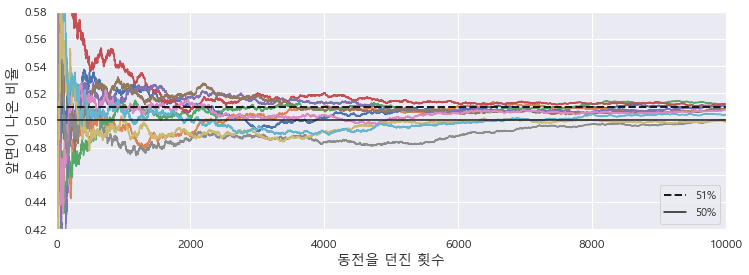

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("동전을 던진 횟수")
plt.ylabel("앞면이 나온 비율")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

투표 기반 분류기

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
# 사이킷런의 VotingClassifier 사용
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


## 7.2 배깅과 페이스팅

### 7.2.1 사이킷런의 배깅과 페이스팅

﻿결정 트리 분류기 500개의 앙상블 훈련

In [8]:
#데이터 셋
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
# 사이킷런은 배깅과 페이스팅을 위해 간편한 API로 구성된 BaggingClassifier를 제공
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.92


In [10]:
#단 하나의 Decision Tree를 사용할 경우
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


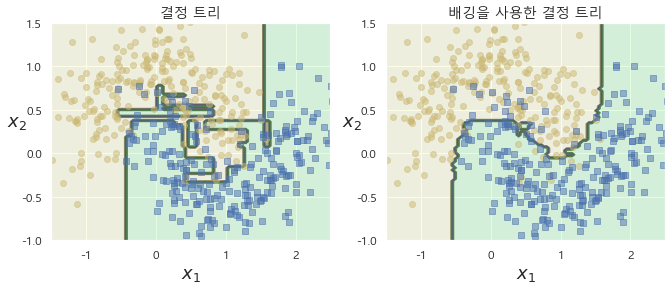

In [11]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

### 7.2.2 obb 평가

In [12]:
# BaggingClassifier를 만들 때 oob_score=True로 지정하면 oob평가 수행
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
print("oob score : ", bag_clf.oob_score_)

oob score :  0.8986666666666666


In [13]:
# 테스트 세트에서의 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [14]:
#결정 함수 값
bag_clf.oob_decision_function_[:5]

array([[0.40883978, 0.59116022],
       [0.32934132, 0.67065868],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.4 랜덤 포레스트

랜덤 포레스트 분류기 / BaggingClassifier를 사용해 유사하게 만들기

In [15]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

#BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

# 두 모델의 예측 비교
print(np.sum(y_pred == y_pred_rf) / len(y_pred))

0.928


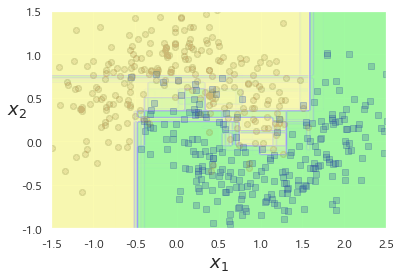

In [16]:
#시각화
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 7.4.1 엑스트라 트리

랜덤 포레스트와 엑스트라 트리 비교

In [17]:
# 사이킷런의 ExtraTressClassifier 사용
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_clf.fit(X_train, y_train)
y_pred_ext = extra_clf.predict(X_test)

# 두 모델의 예측 비교
print(np.sum(y_pred_rf == y_pred_ext) / len(y_pred_rf))

0.976


### 7.4.2 특성 중요도

﻿iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력

In [18]:
#RandomForestClassifier 훈련 후 각 특성의 중요도 출력
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09663221310626886
sepal width (cm) 0.02247138117192092
petal length (cm) 0.44224392465822204
petal width (cm) 0.4386524810635881


MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고, 각 픽셀의 중요도 나타내기

In [19]:
#MNIST 데이터의 각 픽셀 중요도 알아보기
from tensorflow.keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

X = np.vstack((train_x, test_x))
X = X.reshape([-1, 28*28])
y = np.append(train_y, test_y)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

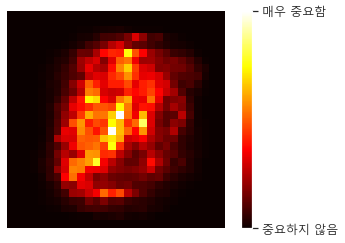

In [21]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요함'])

plt.show()

## 7.5 부스팅

### 7.5.1 에이다부스트

In [22]:
#moons데이터셋에 AdaBoostClassifier 모델 학습
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

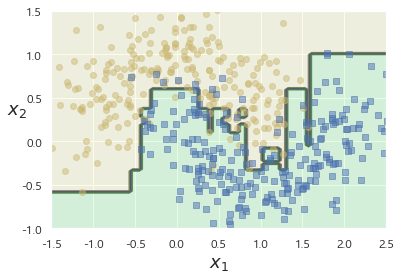

In [24]:
plot_decision_boundary(ada_clf, X, y)

### 7.5.2 그레이디언트 부스팅

결정 트리 기반 예측기로 사용하는 간단한 회귀 문제

In [25]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [26]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [27]:
#첫 번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [28]:
#두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [29]:
X_new = np.array([[0.8]])  # new data

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print('y_pred :', y_pred)

y_pred : [0.75026781]


sklearn의 GradientBoostingRegressor을 사용한  GBRT 훈련

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

In [31]:
print('y_pred :', gbrt.predict(X_new))

y_pred : [0.75026781]


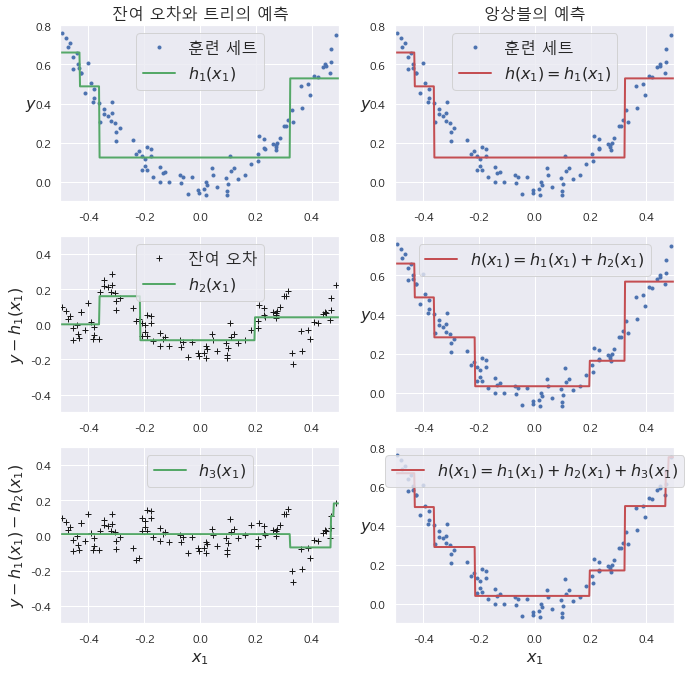

In [32]:
#시각화
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("잔여 오차와 트리의 예측", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("앙상블의 예측", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="잔여 오차")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [33]:
#GBRT를 학습시킨 후 staged_predict() 메소드를 이용해 각 모델의 예측값(y_pred)과 실제값(y_val)의
#MSE를 구한 뒤 MSE가장 낮은 최적의 트리의 개수를 찾아
#다시 최적의 트리 개수(best_n_estimator)로 그래디언트 부스팅을 학습시키는 예제
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

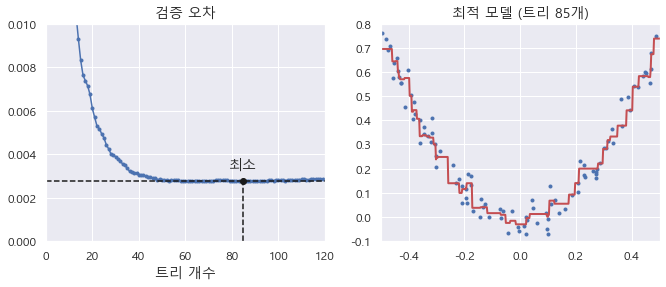

In [34]:
#시각화
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "최소", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("트리 개수")
plt.title("검증 오차", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("최적 모델 (트리 %d개)" % bst_n_estimators, fontsize=14)

plt.show()

Early Stopping을 이용한 그래디언트 부스팅

In [35]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [36]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 100
최소 검증 MSE: 0.0027874098179574477


XGBoost

In [37]:
!pip install xgboost

In [38]:
#XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [39]:
# 조기 종료도 지원하는 XGBoost
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.22055
[1]	validation_0-rmse:0.16547
[2]	validation_0-rmse:0.12243
[3]	validation_0-rmse:0.10044
[4]	validation_0-rmse:0.08467
[5]	validation_0-rmse:0.07344
[6]	validation_0-rmse:0.06728
[7]	validation_0-rmse:0.06383
[8]	validation_0-rmse:0.06125
[9]	validation_0-rmse:0.05959
[10]	validation_0-rmse:0.05902
[11]	validation_0-rmse:0.05852
[12]	validation_0-rmse:0.05844
[13]	validation_0-rmse:0.05801
[14]	validation_0-rmse:0.05747
[15]	validation_0-rmse:0.05772


In [40]:
xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 7.6 스태킹